In [4]:
import os
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

In [55]:
# python -m Models

# General
import tensorflow as tf
from tensorflow.keras import backend as K
# import segmentation_models as sm

# Network Architecture
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, Dropout
from keras.optimizers import Adam

# Metrics
from keras.metrics import MeanIoU


############################################################################################################################################################################

# Dice coefficient - Metric
# really useful in image segmentation tasks with imbalanced data
# could also be used as a loss
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)


# IoU (already imported) - Metric
def IoU(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return intersection / union

############################################################################################################################################################################

# BLOCKS
def contraction_block(input_tensor, num_filters, dropout_rate):
    x = Conv2D(num_filters, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(input_tensor)      # strides default to 1

    # Dropout rate in between the Conv layers -> we got better results
    if dropout_rate > 0:
        x = Dropout(rate = dropout_rate)(x)
    
    x = Conv2D(num_filters, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)

    pooled = MaxPooling2D((2, 2))(x)            # OG paper proposed strides=2 but we leave them default to pool_size = 2
    return x, pooled


# will be useful also for autoencoder
def convolution_block(input_tensor, num_filters, dropout_rate):
    x = Conv2D(num_filters, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(input_tensor)      # strides default to 1
    if dropout_rate > 0:
        x = Dropout(rate = dropout_rate)(x)
    x = Conv2D(num_filters, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    return x

# for autoencoder upsample
def upsample_block(input_tensor, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides = (2, 2), padding='same')(input_tensor)
    x = Conv2D(num_filters, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)      # strides default to 1
    x = Conv2D(num_filters, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    return x


def expansive_block(copy, input_tensor, num_filters, dropout_rate):
    '''
    documentation
    '''    
    # Conv2dtranspose =! upsampling (both the concept and the keras layer). both increase dim of arrays.
    # upsampling2d is the opposite of pooling repeating rows and columns of input.
    # Conv2dtranspose performs upsampling and then convolution. 
    x = Conv2DTranspose(num_filters, (2, 2), strides = (2, 2), padding='same')(input_tensor)       

    # Concatenation: crop the copy from the specular contraction block and concatenate it to the
    # current respective decoder layer of the expansive path
    concatenation = concatenate([x, copy])

    # add simple 2D convolutions
    x = Conv2D(num_filters, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(concatenation)

    if dropout_rate > 0:
        x = Dropout(rate = dropout_rate)(x)

    x = Conv2D(num_filters, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)

    return x


###### CHANGE NUM FILTERS TO NUM_FILTERS: NUM_FILTERS,*2,*4,*8,*16,*8,*4,*2,NUM_FILTERS and the last conv2d with NUM_CLASSES #########
# Simple UNET
def Unet(input_size, num_classes:int, dropout_rates:list):
    
    input_layer = Input(input_size)

    copy1, p1 = contraction_block(input_tensor=input_layer, num_filters=32, dropout_rate=dropout_rates[0])
    copy2, p2 = contraction_block(input_tensor=p1, num_filters=64, dropout_rate=dropout_rates[0])
    copy3, p3 = contraction_block(input_tensor=p2, num_filters=128, dropout_rate=dropout_rates[1])
    copy4, p4 = contraction_block(input_tensor=p3, num_filters=256, dropout_rate=dropout_rates[1])

    x5 = convolution_block(input_tensor=p4, num_filters=512, dropout_rate = dropout_rates[2])

    p6 = expansive_block(copy=copy4, input_tensor=x5, num_filters=256, dropout_rate = dropout_rates[1])
    p7 = expansive_block(copy=copy3, input_tensor=p6, num_filters=128, dropout_rate = dropout_rates[1])
    p8 = expansive_block(copy=copy2, input_tensor=p7, num_filters=64, dropout_rate = dropout_rates[0])
    p9 = expansive_block(copy=copy1, input_tensor=p8, num_filters=32, dropout_rate = dropout_rates[0])

    # Due to mirror-like shape of the UNET architecture, f9 == num_classes
    # since multiclass task use Softmax activation function
    output = Conv2D(filters=num_classes, kernel_size=(1, 1), activation='softmax')(p9)
    
    model = Model(inputs=[input_layer], outputs=[output], name='Unet')
    return model


# Autoencoder
def encoder(inputs):
    # will not use the copies since there are no skip connections
    copy1, p1 = contraction_block(input_tensor = inputs, num_filters = 32, dropout_rate=0)
    copy2, p2 = contraction_block(input_tensor = p1, num_filters = 64, dropout_rate=0)
    copy3, p3 = contraction_block(input_tensor = p2, num_filters = 128, dropout_rate=0)
    copy4, p4 = contraction_block(input_tensor = p3, num_filters = 256, dropout_rate=0)

    p5 = convolution_block(input_tensor = p4, num_filters = 512, dropout_rate = 0)
    return p5

def decoder(inputs):
    u1 = upsample_block(input_tensor = inputs, num_filters = 256)
    u2 = upsample_block(input_tensor = u1, num_filters = 128)
    u3 = upsample_block(input_tensor = u2, num_filters = 64)
    u4 = upsample_block(input_tensor = u3, num_filters = 32)
    decoded = Conv2D(3, 3, padding="same", activation="sigmoid")(u4)        # sigmoid since reconstruction
    return decoded

def autoencoder(input_size):
    input_layer = Input(input_size)
    autoencoder = Model(input_layer, decoder(encoder(input_layer)))
    return autoencoder


In [6]:
## defining a frame for image and mask storage
framObjTrain = {'img' : [],
           'mask' : []
          }

framObjValidation = {'img' : [],
           'mask' : []
          }
framObjTest = {'img' : [],
           'mask' : []
          }
## defining data Loader function
def LoadData( frameObj = None, imgPath = None, maskPath = None, shape = 256):
    imgNames = os.listdir(imgPath)
    maskNames = []
    
    ## generating mask names
    for mem in imgNames:
        maskNames.append(re.sub('\.png', '_L.png', mem))
    
    imgAddr = imgPath + '/'
    maskAddr = maskPath + '/'
    
    for i in range (len(imgNames)):
        img = plt.imread(imgAddr + imgNames[i])
        mask = plt.imread(maskAddr + maskNames[i])
        
        img = cv2.resize(img, (shape, shape)) 
        mask = cv2.resize(mask, (shape, shape))
        
        frameObj['img'].append(img)
        frameObj['mask'].append(mask)
        
    return frameObj
        
    
 
    
   
framObjTrain = LoadData( framObjTrain, imgPath = '/kaggle/input/camvid/CamVid/train', maskPath = '/kaggle/input/camvid/CamVid/train_labels'
         , shape = 256)
framObjValidation  = LoadData( framObjValidation, imgPath = '/kaggle/input/camvid/CamVid/val', maskPath = '/kaggle/input/camvid/CamVid/val_labels'
         , shape = 256)
framObjTest  = LoadData( framObjTest, imgPath = '/kaggle/input/camvid/CamVid/test', maskPath = '/kaggle/input/camvid/CamVid/test_labels'
         , shape = 256)

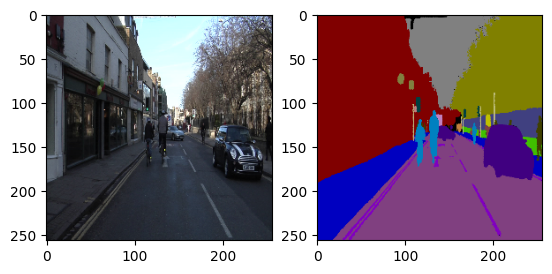

In [7]:
plt.subplot(1,2,1)
plt.imshow(framObjTrain['img'][1])
plt.subplot(1,2,2)
plt.imshow(framObjTrain['mask'][1])
plt.show()

In [12]:
IMG_HEIGHT = 256
IMG_WIDTH  = 256
IMG_CHANNELS = 3

shapes = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
model = Unet(shapes, num_classes=32, dropout_rates=[0, 0, 0])
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', dice_coef, IoU])
model.summary()


Model: "Unet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_19 (Conv2D)          (None, 256, 256, 32)         896       ['input_2[0][0]']             
                                                                                                  
 conv2d_20 (Conv2D)          (None, 256, 256, 32)         9248      ['conv2d_19[0][0]']           
                                                                                                  
 max_pooling2d_4 (MaxPoolin  (None, 128, 128, 32)         0         ['conv2d_20[0][0]']           
 g2D)                                                                                          

In [16]:
# this block essentially performs 2 convolution

def Conv2dBlock(inputTensor, numFilters, kernelSize = 3, doBatchNorm = True):
    #first Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (inputTensor)
    
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x =tf.keras.layers.Activation('relu')(x)
    
    #Second Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (x)
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x = tf.keras.layers.Activation('relu')(x)
    
    return x


# Now defining Unet 
def GiveMeUnet(inputImage, numFilters = 16, droupouts = 0.1, doBatchNorm = True):
    # defining encoder Path
    c1 = Conv2dBlock(inputImage, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(droupouts)(p1)
    
    c2 = Conv2dBlock(p1, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(droupouts)(p2)
    
    c3 = Conv2dBlock(p2, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(droupouts)(p3)
    
    c4 = Conv2dBlock(p3, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(droupouts)(p4)
    
    c5 = Conv2dBlock(p4, numFilters * 16, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    # defining decoder path
    u6 = tf.keras.layers.Conv2DTranspose(numFilters*8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(droupouts)(u6)
    c6 = Conv2dBlock(u6, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u7 = tf.keras.layers.Conv2DTranspose(numFilters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(droupouts)(u7)
    c7 = Conv2dBlock(u7, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u8 = tf.keras.layers.Conv2DTranspose(numFilters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(droupouts)(u8)
    c8 = Conv2dBlock(u8, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u9 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(droupouts)(u9)
    c9 = Conv2dBlock(u9, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    output = tf.keras.layers.Conv2D(3, (1, 1), activation = 'sigmoid')(c9)
    model = tf.keras.Model(inputs = [inputImage], outputs = [output])
    return model

## instanctiating model
inputs = tf.keras.layers.Input((256, 256, 3))
myTransformer = GiveMeUnet(inputs, droupouts= 0.07)
myTransformer.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'] )

In [17]:
retVal = myTransformer.fit(np.array(framObjTrain['img']),np.array(framObjTrain['mask']), epochs = 100, verbose = 1)

Epoch 1/100


2024-01-31 17:34:17.536886: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1706722467.963558     260 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


12/12 [==============================] - 47s 1s/step - loss: 0.7176 - accuracy: 0.1798
Epoch 2/100
12/12 [==============================] - 6s 498ms/step - loss: 0.6576 - accuracy: 0.2525
Epoch 3/100
12/12 [==============================] - 6s 499ms/step - loss: 0.6333 - accuracy: 0.3834
Epoch 4/100
12/12 [==============================] - 6s 503ms/step - loss: 0.6172 - accuracy: 0.4488
Epoch 5/100
12/12 [==============================] - 6s 505ms/step - loss: 0.6034 - accuracy: 0.4639
Epoch 6/100
12/12 [==============================] - 6s 508ms/step - loss: 0.5924 - accuracy: 0.4717
Epoch 7/100
12/12 [==============================] - 6s 512ms/step - loss: 0.5812 - accuracy: 0.4816
Epoch 8/100
12/12 [==============================] - 6s 518ms/step - loss: 0.5713 - accuracy: 0.4835
Epoch 9/100
12/12 [==============================] - 6s 522ms/step - loss: 0.5616 - accuracy: 0.4810
Epoch 10/100
12/12 [==============================] - 6s 526ms/step - loss: 0.5560 - accuracy: 0.4822
Epo

In [26]:
model = Unet((256, 256, 3), num_classes=3, dropout_rates=[0.1, 0.2, 0.3])
model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'] )

In [27]:
history = model.fit(np.array(framObjTrain['img']),np.array(framObjTrain['mask']), epochs = 100, verbose = 1)

Epoch 1/100


2024-01-31 17:56:39.166144: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inUnet/dropout_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


12/12 [==============================] - 76s 3s/step - loss: 0.6517 - accuracy: 0.7598
Epoch 2/100
12/12 [==============================] - 9s 768ms/step - loss: 0.6247 - accuracy: 0.8019
Epoch 3/100
12/12 [==============================] - 9s 771ms/step - loss: 0.6136 - accuracy: 0.8087
Epoch 4/100
12/12 [==============================] - 9s 770ms/step - loss: 0.6049 - accuracy: 0.7370
Epoch 5/100
12/12 [==============================] - 9s 769ms/step - loss: 0.5975 - accuracy: 0.6301
Epoch 6/100
12/12 [==============================] - 9s 766ms/step - loss: 0.5982 - accuracy: 0.5673
Epoch 7/100
12/12 [==============================] - 9s 766ms/step - loss: 0.5932 - accuracy: 0.6062
Epoch 8/100
12/12 [==============================] - 9s 766ms/step - loss: 0.5922 - accuracy: 0.5910
Epoch 9/100
12/12 [==============================] - 9s 764ms/step - loss: 0.5888 - accuracy: 0.5769
Epoch 10/100
12/12 [==============================] - 9s 765ms/step - loss: 0.5831 - accuracy: 0.5481
Epo

In [35]:
model_focal = Unet((256, 256, 3), num_classes=3, dropout_rates=[0.1, 0.2, 0.3])
model_focal.compile(optimizer = 'Adam', loss = 'binary_focal_crossentropy', metrics = ['accuracy'] )

In [36]:
history_focal = model_focal.fit(np.array(framObjTrain['img']),np.array(framObjTrain['mask']), epochs = 40, verbose = 1)

Epoch 1/40


2024-01-31 18:19:32.875560: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inUnet/dropout_35/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


12/12 [==============================] - 15s 759ms/step - loss: 0.1453 - accuracy: 0.6919
Epoch 2/40
12/12 [==============================] - 9s 764ms/step - loss: 0.1365 - accuracy: 0.8149
Epoch 3/40
12/12 [==============================] - 9s 782ms/step - loss: 0.1341 - accuracy: 0.7618
Epoch 4/40
12/12 [==============================] - 10s 793ms/step - loss: 0.1342 - accuracy: 0.6843
Epoch 5/40
12/12 [==============================] - 9s 787ms/step - loss: 0.1315 - accuracy: 0.5681
Epoch 6/40
12/12 [==============================] - 9s 770ms/step - loss: 0.1289 - accuracy: 0.6035
Epoch 7/40
12/12 [==============================] - 9s 760ms/step - loss: 0.1268 - accuracy: 0.6216
Epoch 8/40
12/12 [==============================] - 9s 755ms/step - loss: 0.1250 - accuracy: 0.6282
Epoch 9/40
12/12 [==============================] - 9s 752ms/step - loss: 0.1233 - accuracy: 0.6348
Epoch 10/40
12/12 [==============================] - 9s 755ms/step - loss: 0.1236 - accuracy: 0.6152
Epoch 11

In [46]:
model_focal_16f = Unet((256, 256, 3), num_classes=3, dropout_rates=[0.1, 0.2, 0.3])
model_focal_16f.compile(optimizer = 'Adam', loss = 'binary_focal_crossentropy', metrics = ['accuracy', dice_coef, IoU] )

In [47]:
history_focal_16f = model_focal_16f.fit(np.array(framObjTrain['img']),np.array(framObjTrain['mask']), epochs = 40, verbose = 1)

Epoch 1/40


2024-01-31 18:41:30.081719: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inUnet/dropout_62/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


12/12 [==============================] - 20s 719ms/step - loss: 0.1838 - accuracy: 0.0728 - dice_coef: 0.4005 - IoU: 0.2504
Epoch 2/40
12/12 [==============================] - 5s 393ms/step - loss: 0.1633 - accuracy: 0.1444 - dice_coef: 0.3749 - IoU: 0.2308
Epoch 3/40
12/12 [==============================] - 5s 394ms/step - loss: 0.1541 - accuracy: 0.4077 - dice_coef: 0.3495 - IoU: 0.2117
Epoch 4/40
12/12 [==============================] - 5s 391ms/step - loss: 0.1484 - accuracy: 0.6422 - dice_coef: 0.3591 - IoU: 0.2190
Epoch 5/40
12/12 [==============================] - 5s 387ms/step - loss: 0.1442 - accuracy: 0.7314 - dice_coef: 0.3564 - IoU: 0.2169
Epoch 6/40
12/12 [==============================] - 5s 386ms/step - loss: 0.1400 - accuracy: 0.7075 - dice_coef: 0.3584 - IoU: 0.2183
Epoch 7/40
12/12 [==============================] - 5s 383ms/step - loss: 0.1383 - accuracy: 0.7298 - dice_coef: 0.3636 - IoU: 0.2222
Epoch 8/40
12/12 [==============================] - 5s 381ms/step - loss

---

In [56]:
# autoencoder
autoenc = autoencoder((256,256,3))

In [57]:
autoenc.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])
autoenc.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_200 (Conv2D)         (None, 256, 256, 32)      896       
                                                                 
 conv2d_201 (Conv2D)         (None, 256, 256, 32)      9248      
                                                                 
 max_pooling2d_44 (MaxPooli  (None, 128, 128, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_202 (Conv2D)         (None, 128, 128, 64)      18496     
                                                                 
 conv2d_203 (Conv2D)         (None, 128, 128, 64)      36928     
                                                           

In [61]:
autoenc.fit(np.array(framObjTrain['img']), np.array(framObjTrain['img']), epochs = 50, verbose = 1)

Epoch 1/50
12/12 [==============================] - 6s 502ms/step - loss: 0.0839 - accuracy: 0.4961
Epoch 2/50
12/12 [==============================] - 6s 497ms/step - loss: 0.0536 - accuracy: 0.4383
Epoch 3/50
12/12 [==============================] - 6s 492ms/step - loss: 0.0320 - accuracy: 0.4446
Epoch 4/50
12/12 [==============================] - 6s 490ms/step - loss: 0.0241 - accuracy: 0.4848
Epoch 5/50
12/12 [==============================] - 6s 490ms/step - loss: 0.0212 - accuracy: 0.4985
Epoch 6/50
12/12 [==============================] - 6s 492ms/step - loss: 0.0190 - accuracy: 0.4992
Epoch 7/50
12/12 [==============================] - 6s 494ms/step - loss: 0.0178 - accuracy: 0.4966
Epoch 8/50
12/12 [==============================] - 6s 498ms/step - loss: 0.0167 - accuracy: 0.4987
Epoch 9/50
12/12 [==============================] - 6s 500ms/step - loss: 0.0164 - accuracy: 0.4980
Epoch 10/50
12/12 [==============================] - 6s 502ms/step - loss: 0.0156 - accuracy: 0.4962

In [67]:
pred = autoenc.predict(np.array(framObjValidation['img'][0:20]))

1/1 [==============================] - 5s 5s/step


In [70]:
for i in range(len(pred)):
        pred[i] = cv2.merge((pred[i,:,:,0],pred[i,:,:,1],pred[i,:,:,2]))

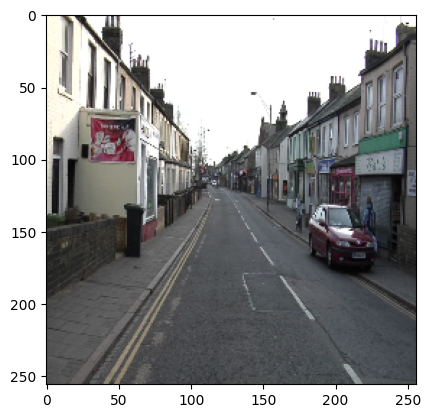

In [68]:
plt.imshow(np.array(framObjValidation['img'][1]))

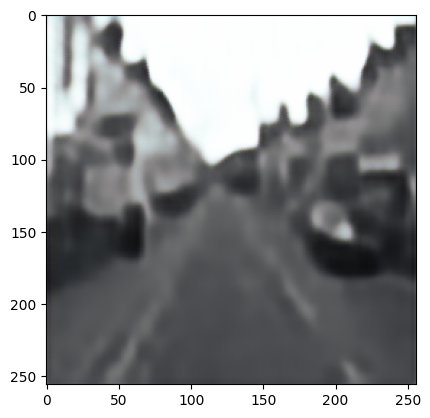

In [71]:
plt.imshow(pred[1])

1/1 [==============================] - 0s 276ms/step


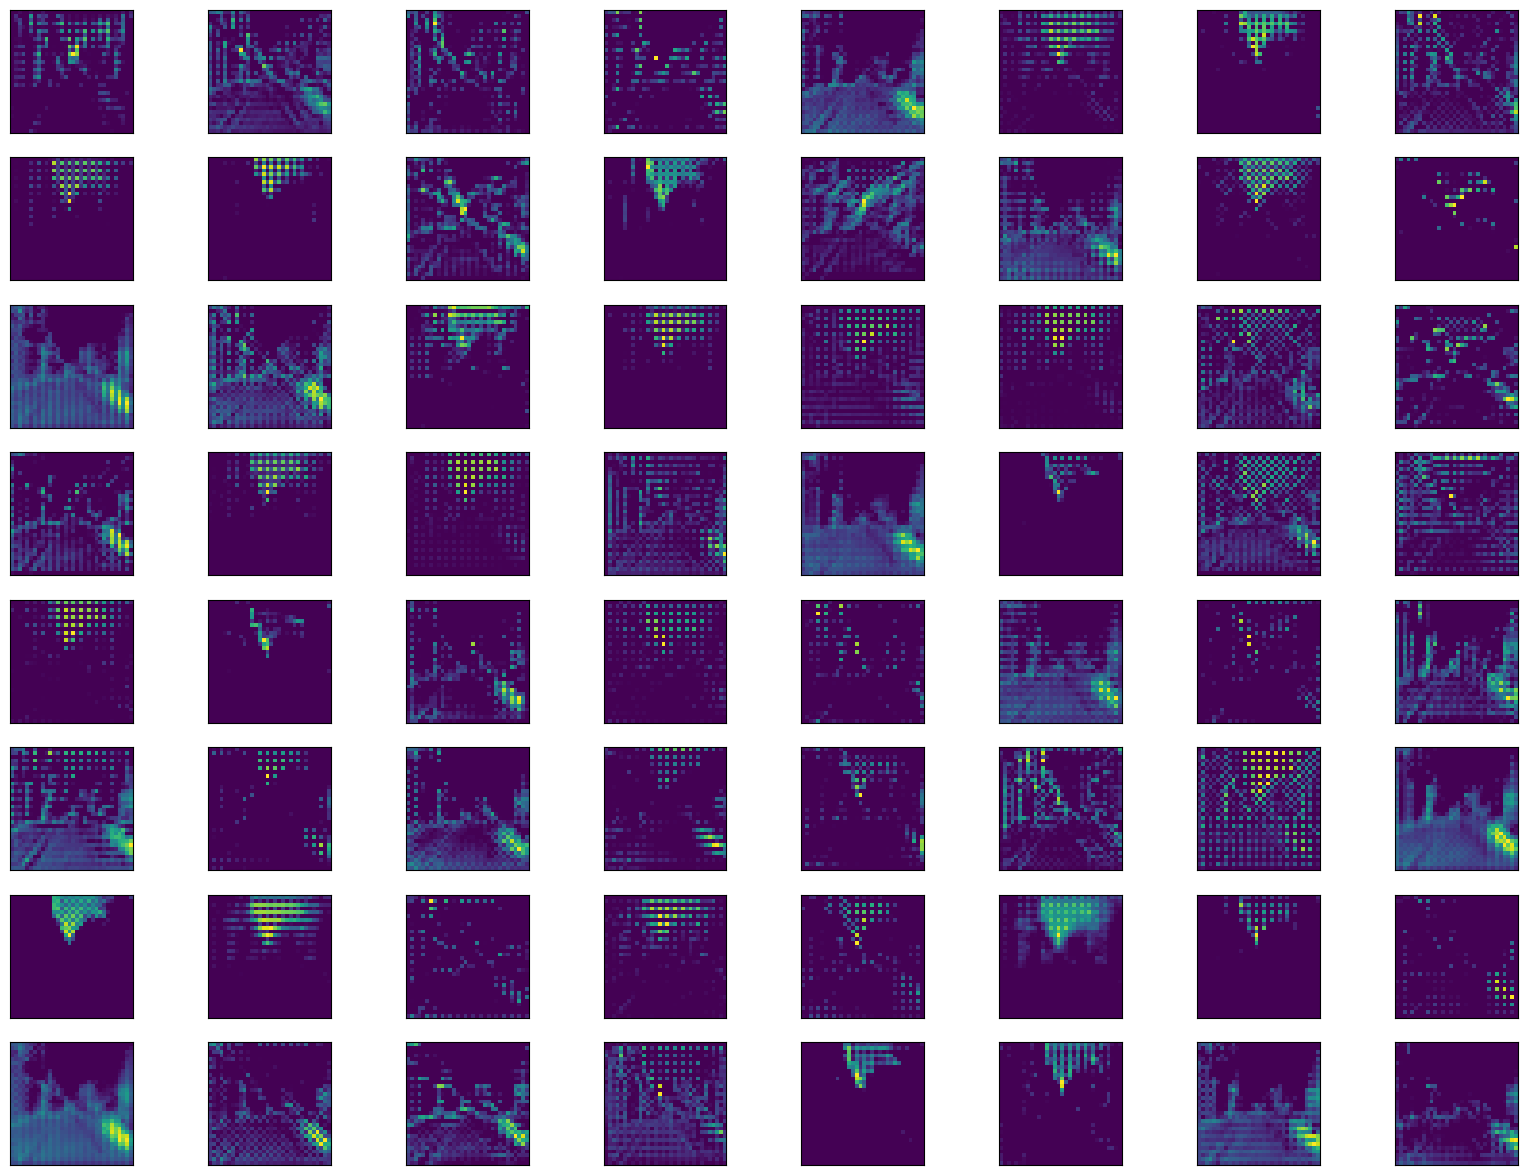

In [78]:
my_model = autoenc

#set intermediate representations for all layers in the model
# except for the first - as it is an input layer
outputs = [layer.output for layer in my_model.layers[1:]]

model_for_visualization = Model(inputs = my_model.input, outputs = outputs)

#Generate random image to be used as input
# img = np.uint8(np.random.uniform(120, 200, (256, 256, 3)))/255
# input_img = np.expand_dims(img, axis=0)

input_img = np.array(framObjValidation['img'][0:20])
feature_maps = model_for_visualization.predict(input_img)

#layer_names = [layer.name for layer in model2.layers]

# plot all 64 maps in an 8x8 squares
#import random
#layer_num = random.randint(0, len(feature_maps)-1)
layer_num = 15 #Depth of layer...
square = 8
ix = 1
plt.figure(figsize=(20,15))
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = plt.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(feature_maps[layer_num][0, :, :, ix-1])
		ix += 1
# show the figure
plt.show()

---

In [18]:
np.array(framObjTrain['img']).shape, np.array(framObjTrain['mask']).shape

((369, 256, 256, 3), (369, 256, 256, 3))

In [22]:
## function for getting 16 predictions
def predict16 (valMap, model, shape = 256):
    ## getting and proccessing val data
    #model.load_weights('/kaggle/input/weights-and-vedio/model_weights_150_runs.h5')

    
    img = valMap['img']
    mask = valMap['mask']
    mask = mask[0:16]
    
    imgProc = img [0:16]
    imgProc = np.array(img)
    
    predictions = model.predict(imgProc)
    for i in range(len(predictions)):
        predictions[i] = cv2.merge((predictions[i,:,:,0],predictions[i,:,:,1],predictions[i,:,:,2]))
    
    return predictions, imgProc, mask
    

    
    
def Plotter(img, predMask, groundTruth):
    plt.figure(figsize=(7,7))
    
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title('image')
    
    plt.subplot(1,3,2)
    plt.imshow(predMask)
    plt.title('Predicted Mask')
    
    plt.subplot(1,3,3)
    plt.imshow(groundTruth)
    plt.title('actual Mask')

In [23]:
sixteenPrediction, actuals, masks = predict16(framObjValidation, myTransformer)

4/4 [==============================] - 3s 753ms/step


In [28]:
sixteenPrediction2, actuals2, masks2 = predict16(framObjValidation, model)

4/4 [==============================] - 4s 1s/step


In [38]:
sixteenPrediction3, actuals3, masks3 = predict16(framObjValidation, model_focal)

4/4 [==============================] - 1s 164ms/step


In [48]:
sixteenPrediction4, actuals4, masks4 = predict16(framObjValidation, model_focal_16f)

4/4 [==============================] - 2s 576ms/step


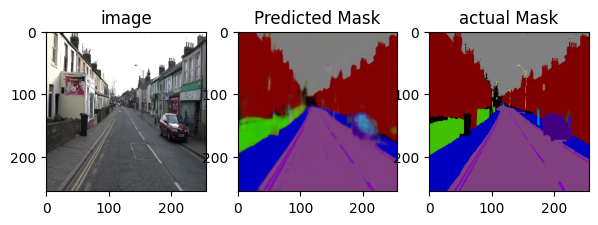

In [24]:
# binary CE model of boss (100 epochs)
Plotter(actuals[1], sixteenPrediction[1], masks[1])

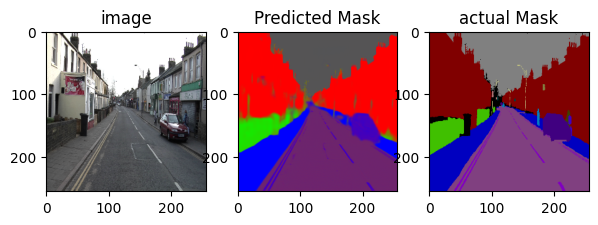

In [29]:
#binary CE our unet (100 epochs)
Plotter(actuals2[1], sixteenPrediction2[1], masks2[1])

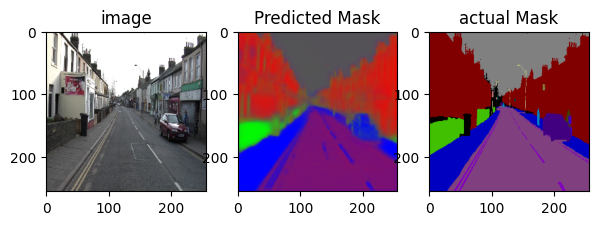

In [51]:
# focal our unet (40 epochs)
Plotter(actuals3[1], sixteenPrediction3[1], masks3[1])

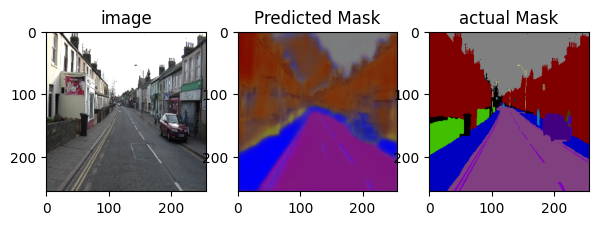

In [50]:
# focal our unet (40 epochs) 16 filters
Plotter(actuals4[1], sixteenPrediction4[1], masks4[1])